Notebook de análisis exploratorio de datos.

Indice:

1.Importando librerias necesarias
2.Conexion a la base de datos local de postgresql
3.Analisis de balance de clase
4.Descripcion  cuantitativa de los casos de fraude segun las caracteristicas de la reclamacion.

**Descripción del problema:** 

El objetivo de este analisis explotario de datos es obtener insigths con respecto a las caracteristicas de las personas con tendencias a cometer fraude a la hora de solicitar el desembolso del seguro contratado.
Se dice que se comete fraude en una reclamacion de seguro, si a la hora de reclamar el pago del mismo, se miente con respecto a los daños sufridos  o se declaran daños mayores a los reales para obtener un beneficio economico mucho mayor al justificado.
El dataset  en cuestion contiene 15420 registros de reclamaciones de seguros como consecuencia de accidentes de transito.
Este dataset contiene  33 columnas que dan cuenta de las caracteristicas de la reclamacion, mostrando datos como el sexo de quien tuvo el accidente, edad, tipo de vehiculo, numero de vehiculos involucrados en el accidente, mes del accidente y la reclamacion, dia del accidente y la reclamacion, entre otros datos relevantes que permiten estudiar de manera cuantitativa los casos y determinar cuales de estas caracteristicas pueden ser señales de alerta para los agentes , con miras a reducir las perdidas por fraude a la hora de vender y pagar estos seguros. La variable fraudfound_p indica si la reclamacion en cuestion ha sido identificada como fraudulenta o no fraudulenta.



**Importando librerias necesarias**


In [3]:

import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from prettytable import PrettyTable
import numpy as np
import scipy.stats as ss
from scipy.stats import f_oneway





Conexion a la base de datos Local de postgres y consulta para obtener una base de datos lo mas limpia posible para inciar el trabajo de análisis

**nota: por motivos de seguridad nunca se deben dejar las credenciales de la conexion a una base de datos en el notebook, en este caso se hace simplemente para mostrar como se desarrollo la conexion, estas credenciales no deben subirse a ningun lado.** 

In [4]:
#parametros de conexion
host = 'localhost'
port = '5432'
database = 'DataScientistR5'
user = 'postgres'
password = 'nico1998'

#ejecutar conexion
conn = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password
)

nombre_tabla = "fraudes"
query =f"SELECT DISTINCT \
    Monthh, \
    WeekOfMonth, \
    DayOfWeek, \
    Make, \
    AccidentArea, \
    NULLIF(DayOfWeekClaimed, '0') AS DayOfWeekClaimed, \
    NULLIF(MonthClaimed, '0') AS MonthClaimed, \
    WeekOfMonthClaimed, \
    Sex, \
    MaritalStatus, \
    NULLIF(Age, 0) AS Age, \
    Fault, \
    PolicyType, \
    VehicleCategory, \
    VehiclePrice, \
    FraudFound_P, \
    PolicyNumber, \
    RepNumber, \
    Deductible, \
    DriverRating, \
    CASE \
        WHEN Days_Policy_Accident = 'none' THEN '0' \
        ELSE Days_Policy_Accident \
    END AS Days_Policy_Accident, \
    CASE \
        WHEN Days_Policy_Claim = 'none' THEN '0' \
        ELSE Days_Policy_Claim \
    END AS Days_Policy_Claim, \
    CASE \
        WHEN PastNumberOfClaims = 'none' THEN '0' \
        ELSE PastNumberOfClaims \
    END AS PastNumberOfClaims, \
    AgeOfVehicle, \
    AgeOfPolicyHolder, \
    CASE \
        WHEN PoliceReportFiled = 'Yes' THEN 1 \
        WHEN PoliceReportFiled = 'No' THEN 0 \
        ELSE NULL \
    END AS PoliceReportFiled, \
    CASE \
        WHEN WitnessPresent = 'Yes' THEN 1 \
        WHEN WitnessPresent = 'No' THEN 0 \
        ELSE NULL \
    END AS WitnessPresent, \
    AgentType, \
    CASE \
        WHEN NumberOfSuppliments = 'none' THEN '0' \
        ELSE NumberOfSuppliments\
    END AS NumberOfSuppliments, \
    AddressChange_Claim, \
    NumberOfCars, \
    Yearr, \
    BasePolicy \
FROM \
    {nombre_tabla}"



# Leer la tabla en un DataFrame de pandas
df = pd.read_sql(query, conn)

conn.close()


C:\Users\USER\AppData\Local\Temp\ipykernel_16432\650483787.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   monthh                15420 non-null  object 
 1   weekofmonth           15420 non-null  int64  
 2   dayofweek             15420 non-null  object 
 3   make                  15420 non-null  object 
 4   accidentarea          15420 non-null  object 
 5   dayofweekclaimed      15419 non-null  object 
 6   monthclaimed          15419 non-null  object 
 7   weekofmonthclaimed    15420 non-null  int64  
 8   sex                   15420 non-null  object 
 9   maritalstatus         15420 non-null  object 
 10  age                   15100 non-null  float64
 11  fault                 15420 non-null  object 
 12  policytype            15420 non-null  object 
 13  vehiclecategory       15420 non-null  object 
 14  vehicleprice          15420 non-null  object 
 15  fraudfound_p       

In [6]:
df.head(20)

,monthh,weekofmonth,dayofweek,make,accidentarea,dayofweekclaimed,monthclaimed,weekofmonthclaimed,sex,maritalstatus,...,ageofvehicle,ageofpolicyholder,policereportfiled,witnesspresent,agenttype,numberofsuppliments,addresschange_claim,numberofcars,yearr,basepolicy
0,Jul,2,Friday,Toyota,Urban,Thursday,Jul,3,Male,Married,...,7 years,36 to 40,0,0,External,0,no change,1 vehicle,1994,All Perils
1,May,4,Tuesday,Pontiac,Urban,Wednesday,May,5,Female,Single,...,7 years,36 to 40,0,0,External,0,no change,1 vehicle,1994,All Perils
2,Jan,2,Thursday,Toyota,Urban,Thursday,Jan,2,Male,Married,...,more than 7,51 to 65,0,0,External,3 to 5,no change,1 vehicle,1994,Liability
3,Oct,3,Thursday,Pontiac,Urban,Monday,Oct,4,Male,Married,...,7 years,31 to 35,0,0,External,0,no change,1 vehicle,1996,All Perils
4,Aug,2,Monday,Pontiac,Urban,Tuesday,Aug,2,Male,Married,...,6 years,31 to 35,0,0,External,3 to 5,no change,1 vehicle,1996,All Perils
5,Jun,2,Saturday,Honda,Urban,Monday,Jun,2,Female,Married,...,7 years,36 to 40,0,0,External,more than 5,no change,1 vehicle,1994,Liability
6,Nov,1,Friday,Nisson,Urban,Wednesday,Nov,2,Male,Married,...,more than 7,41 to 50,0,0,External,more than 5,no change,1 vehicle,1994,Collision
7,Apr,3,Monday,Toyota,Urban,Tuesday,Apr,4,Male,Married,...,6 years,31 to 35,0,0,External,0,no change,1 vehicle,1994,Collision
8,Mar,4,Friday,Mazda,Urban,Monday,Mar,5,Male,Married,...,more than 7,41 to 50,0,0,External,more than 5,no change,1 vehicle,1995,All Perils
9,Nov,2,Wednesday,Mazda,Rural,Thursday,Nov,2,Male,Married,...,7 years,36 to 40,0,0,External,0,no change,1 vehicle,1995,Collision


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
weekofmonth,15420.0,2.788586,1.287585,1.0,2.00,3.0,4.00,5.0
weekofmonthclaimed,15420.0,2.693969,1.259115,1.0,2.00,3.0,4.00,5.0
age,15100.0,40.700331,12.309493,16.0,31.00,39.0,49.00,80.0
fraudfound_p,15420.0,0.059857,0.237230,0.0,0.00,0.0,0.00,1.0
policynumber,15420.0,7710.500000,4451.514911,1.0,3855.75,7710.5,11565.25,15420.0
repnumber,15420.0,8.483268,4.599948,1.0,5.00,8.0,12.00,16.0
deductible,15420.0,407.704280,43.950998,300.0,400.00,400.0,400.00,700.0
driverrating,15420.0,2.487808,1.119453,1.0,1.00,2.0,3.00,4.0
policereportfiled,15420.0,0.027756,0.164279,0.0,0.00,0.0,0.00,1.0
witnesspresent,15420.0,0.005642,0.074904,0.0,0.00,0.0,0.00,1.0


Analisis del desbalance de clase:
Para este dataset, se puede observar que la variable que define si el reclamo de siniestro fue fraudulento o no, se encuentra muy desbalanceada ya que en 14997 casos (94.% del total de casos) el reclamo no fue fraudulento y tan solo el 6% de los casos si lo fue, por lo tanto será necesario usar tecnicas de muestreo estraficado a la hora de entrenar los modelos.

In [56]:
df['fraudfound_p'].value_counts()

fraudfound_p
0    14497
1      923
Name: count, dtype: int64

Text(0, 0.5, 'Cantidad')

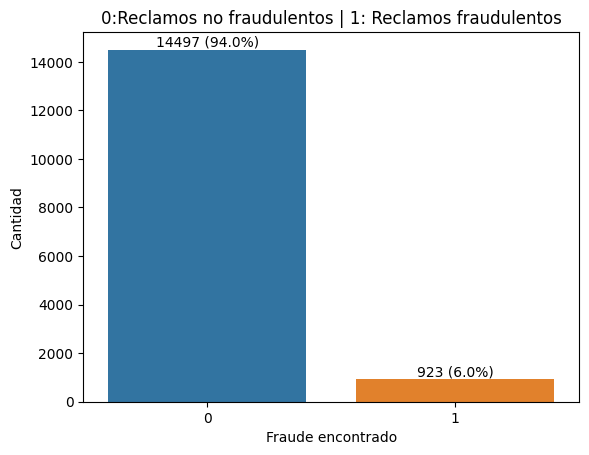

In [9]:
# Obtener el conteo y el porcentaje de cada categoría
count_data = df['fraudfound_p'].value_counts()
percentage_data = df['fraudfound_p'].value_counts(normalize=True) * 100

# Graficar la columna categórica con barras
ax = sns.countplot(x='fraudfound_p', data=df)

# Agregar la cuenta de cantidad y el porcentaje en cada barra
for i, v in enumerate(count_data):
    percentage = percentage_data[count_data.index[i]]
    ax.text(i, v, f"{v} ({percentage:.1f}%)", ha='center', va='bottom')
ax.set_title('0:Reclamos no fraudulentos | 1: Reclamos fraudulentos')

ax.set_xlabel("Fraude encontrado")
ax.set_ylabel("Cantidad")


**Analisis de fraude discriminado por sexo**
A continuación buscaremos responder la pregunta: que genero tiene una mayor tendencia a cometer fraude? 
Para responder esta pregunta necesitamos hacer un muestreo estratificado debido a que en nuestra base de datos el 84.3% de los reclamantes son hombres y el 15.7% de las reclamantes son mujeres.


Text(0, 0.5, 'Cantidad')

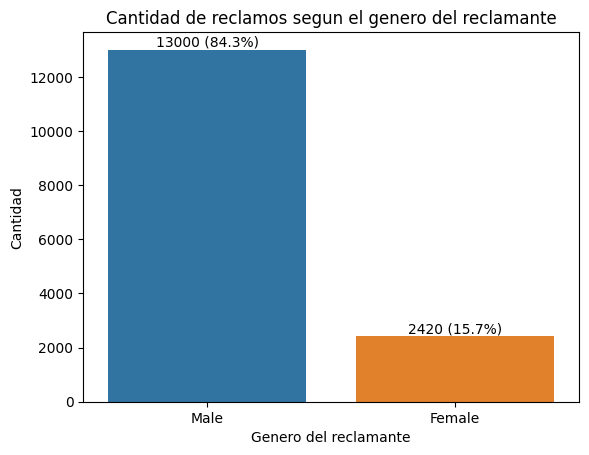

In [10]:
count_data = df['sex'].value_counts()
percentage_data = df['sex'].value_counts(normalize=True) * 100

ax = sns.countplot(x='sex', data=df)

for i, v in enumerate(count_data):
    percentage = percentage_data[count_data.index[i]]
    ax.text(i, v, f"{v} ({percentage:.1f}%)", ha='center', va='bottom')
ax.set_title('Cantidad de reclamos segun el genero del reclamante')

ax.set_xlabel("Genero del reclamante")
ax.set_ylabel("Cantidad")

Cantidad de fraudes segun el genero del reclamante

Text(0, 0.5, 'Cantidad')

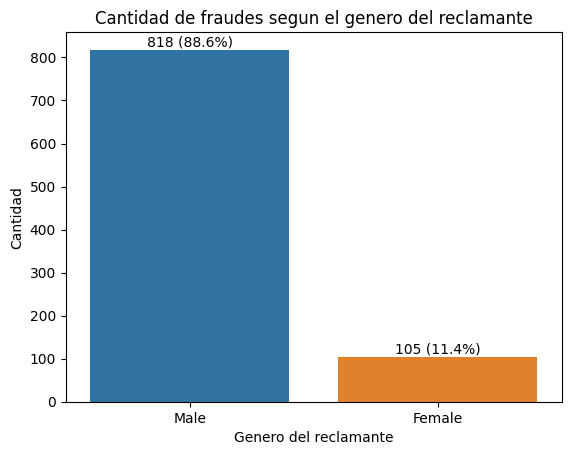

In [50]:
df_ff=df[df['fraudfound_p']==1]
count_data = df_ff['sex'].value_counts()
percentage_data = df_ff['sex'].value_counts(normalize=True) * 100

ax = sns.countplot(x='sex', data=df_ff)

for i, v in enumerate(count_data):
    percentage = percentage_data[count_data.index[i]]
    ax.text(i, v, f"{v} ({percentage:.1f}%)", ha='center', va='bottom')
ax.set_title('Cantidad de fraudes segun el genero del reclamante')

ax.set_xlabel("Genero del reclamante")
ax.set_ylabel("Cantidad")

En la siguiente grafica encontramos  que hay  una leve  diferencia  en la incidencia de fraudes entre los hombres y las mujeres, evidenciando que  un 6.3% de las reclamaciones hechas por hombres resultan ser fraudulentas, frente a un 4.3% de reclamaciones fraudulentas en el caso de las mujeres.

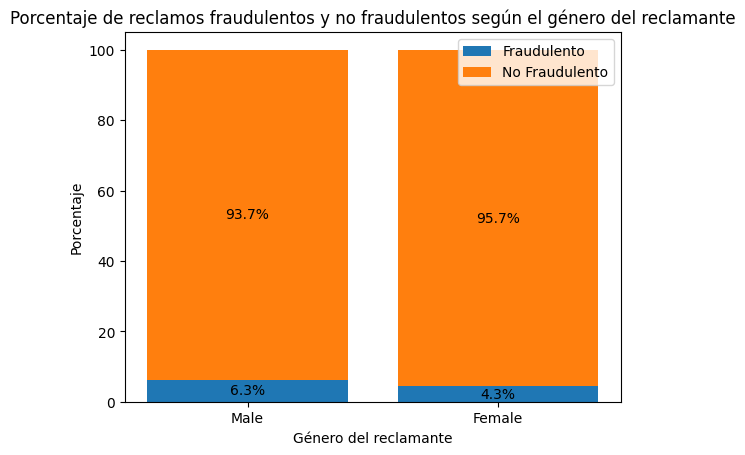

In [11]:

fraudulent_df = df[df['fraudfound_p'] == 1]
non_fraudulent_df = df[df['fraudfound_p'] == 0]

count_data_fraudulent = fraudulent_df['sex'].value_counts()
count_data_non_fraudulent = non_fraudulent_df['sex'].value_counts()
total_count = count_data_fraudulent + count_data_non_fraudulent
percentage_data_fraudulent = (count_data_fraudulent / total_count) * 100
percentage_data_non_fraudulent = (count_data_non_fraudulent / total_count) * 100

fig, ax = plt.subplots()
ax.bar(count_data_fraudulent.index, percentage_data_fraudulent, label='Fraudulento')
ax.bar(count_data_non_fraudulent.index, percentage_data_non_fraudulent, bottom=percentage_data_fraudulent, label='No Fraudulento')

for i, v in enumerate(percentage_data_fraudulent):
    ax.text(i, v/2, f"{v:.1f}%", ha='center', va='center')

for i, v in enumerate(percentage_data_non_fraudulent):
    ax.text(i, v/2 + percentage_data_fraudulent[i], f"{v:.1f}%", ha='center', va='center')

ax.set_title('Porcentaje de reclamos fraudulentos y no fraudulentos según el género del reclamante')
ax.set_xlabel("Género del reclamante")
ax.set_ylabel("Porcentaje")

ax.legend()

plt.show()



In [12]:
df.columns

Index(['monthh', 'weekofmonth', 'dayofweek', 'make', 'accidentarea',
       'dayofweekclaimed', 'monthclaimed', 'weekofmonthclaimed', 'sex',
       'maritalstatus', 'age', 'fault', 'policytype', 'vehiclecategory',
       'vehicleprice', 'fraudfound_p', 'policynumber', 'repnumber',
       'deductible', 'driverrating', 'days_policy_accident',
       'days_policy_claim', 'pastnumberofclaims', 'ageofvehicle',
       'ageofpolicyholder', 'policereportfiled', 'witnesspresent', 'agenttype',
       'numberofsuppliments', 'addresschange_claim', 'numberofcars', 'yearr',
       'basepolicy'],
      dtype='object')

**Reclamaciones por año y  mes** 

En este punto queremos observar la cantidad de reclamaciones fraudulentas y no fraudulentas por cada mes y año en el dataset

En los meses de agosto y marzo del año 1994 se presentaron la mayor cantidad de reclamaciones fraudulentas con un total de 56 casos de fraude en cada uno de esos meses.

In [13]:

count_data = df.groupby(['yearr', 'monthh', 'fraudfound_p']).size().unstack()

table = PrettyTable()
table.field_names = ['Año', 'Mes', 'Casos No Fraudulentos', ' Casos Fraudulentos']

for (year, month), row in count_data.iterrows():
    table.add_row([year, month, row[0], row[1]])

print(table)

+------+-----+-----------------------+---------------------+
| Año  | Mes | Casos No Fraudulentos |  Casos Fraudulentos |
+------+-----+-----------------------+---------------------+
| 1994 | Apr |         486.0         |         47.0        |
| 1994 | Aug |         414.0         |         56.0        |
| 1994 | Dec |         454.0         |         17.0        |
| 1994 | Feb |         492.0         |         36.0        |
| 1994 | Jan |         560.0         |         48.0        |
| 1994 | Jul |         463.0         |         32.0        |
| 1994 | Jun |         496.0         |         47.0        |
| 1994 | Mar |         528.0         |         56.0        |
| 1994 | May |         517.0         |         52.0        |
| 1994 | Nov |         445.0         |         8.0         |
| 1994 | Oct |         446.0         |         1.0         |
| 1994 | Sep |         432.0         |         9.0         |
| 1995 | Apr |         399.0         |         10.0        |
| 1995 | Aug |         3

**Analisis de accidentes segun marca del carro involucrado en el siniestro**
En este punto queremos averiguar las marcas de carros que mas se accidentan.

Los vehiculos de la marca pontiac son, segun los datos, los que presentan una mayor incidencia  de reclamaciones de seguro por accidente.

In [14]:

count_data = df['make'].value_counts()

table = PrettyTable()
table.field_names = ['Marca del vehículo', 'Cantidad de accidentes']

for make, count in count_data.items():
    table.add_row([make, count])

print(table)


+--------------------+------------------------+
| Marca del vehículo | Cantidad de accidentes |
+--------------------+------------------------+
|      Pontiac       |          3837          |
|       Toyota       |          3121          |
|       Honda        |          2801          |
|       Mazda        |          2354          |
|     Chevrolet      |          1681          |
|       Accura       |          472           |
|        Ford        |          450           |
|         VW         |          283           |
|       Dodge        |          109           |
|        Saab        |          108           |
|      Mercury       |           83           |
|       Saturn       |           58           |
|       Nisson       |           30           |
|        BMW         |           15           |
|       Jaguar       |           6            |
|       Porche       |           5            |
|      Mecedes       |           4            |
|      Ferrari       |           2      

**Analisis de reclamos fraudulentos por marca del carro involucrado en el siniestro**
En este punto queremos averiguar las marcas de carros se encuentran mas relacionadas con casos de reclamaciones fraudulentas.

En los datos encontramos pocos casos (4) de accidentes con carros marca mercedes. Esto repercute en el hecho de que el 25% de reclamaciones de seguros por accidentes en autos marca mercedes resulten en reclamaciones fraudulentas. Hay que tener cuidado con los automoviles marca mercedes a la hora de vender los seguros y una recomendacion seria crear discriminaciones en precios para estas marcas, elevando el costo del seguro y endureciendo las condiciones para el pago del seguro contra accidentes en autos de esa marca .

Al margen de esto, encontramos que:
1. cuando los carros accidentados son de la  marca Accura las reclamaciones son fraudulentas en el 12,50% de los casos.
2. cuando los carros accidentados son de la  marca Saab las reclamaciones son fraudulentas en el 10,19% de los casos.
3. cuando los carros accidentados son de la  marca Saturn las reclamaciones son fraudulentas en el 10,34% de los casos.

L

In [15]:
count_data = df.groupby(['make', 'fraudfound_p']).size().unstack().fillna(0)

table = PrettyTable()
table.field_names = ['Marca del vehículo','Total accidentes' ,'Casos fraudulentos', 'Casos no fraudulentos','Porcentaje de casos fraudulentos']

for make, row in count_data.iterrows():
    fraudulent_count = row[1]
    non_fraudulent_count = row[0]
    fraudulent_per=fraudulent_count/(fraudulent_count+non_fraudulent_count)*100
    table.add_row([make,fraudulent_count+non_fraudulent_count, fraudulent_count, non_fraudulent_count,f'{fraudulent_per:.2f}%'])

print(table)



+--------------------+------------------+--------------------+-----------------------+----------------------------------+
| Marca del vehículo | Total accidentes | Casos fraudulentos | Casos no fraudulentos | Porcentaje de casos fraudulentos |
+--------------------+------------------+--------------------+-----------------------+----------------------------------+
|       Accura       |      472.0       |        59.0        |         413.0         |              12.50%              |
|        BMW         |       15.0       |        1.0         |          14.0         |              6.67%               |
|     Chevrolet      |      1681.0      |        94.0        |         1587.0        |              5.59%               |
|       Dodge        |      109.0       |        2.0         |         107.0         |              1.83%               |
|      Ferrari       |       2.0        |        0.0         |          2.0          |              0.00%               |
|        Ford        |  

**Analisis de reclamaciones fraudulentas y no fraudulentas segun area donde sucedio el siniestro**
En esta seccion buscamos responder preguntas como, donde suceden  con mas frecuencia los accidentes asociados a reclamaciones fraudulentas? en el area rural o la urbana ? 
Se observa que el 85.6% de los fraudes detectados estan asociados a accidentes ocurridos en el area urbana mientras que y el 14% en areas rurales. Esto puede deberse a que la cantidad de accidentes que sucede en areas urbanas es mucho mayor.

Text(0, 0.5, 'Cantidad')

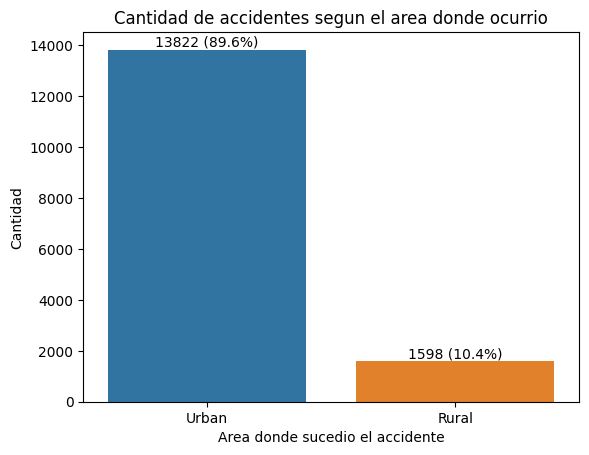

In [55]:

count_data = df['accidentarea'].value_counts()
percentage_data = df['accidentarea'].value_counts(normalize=True) * 100

ax = sns.countplot(x='accidentarea', data=df)

for i, v in enumerate(count_data):
    percentage = percentage_data[count_data.index[i]]
    ax.text(i, v, f"{v} ({percentage:.1f}%)", ha='center', va='bottom')
ax.set_title('Cantidad de accidentes segun el area donde ocurrio')

ax.set_xlabel("Area donde sucedio el accidente")
ax.set_ylabel("Cantidad")

Text(0, 0.5, 'Cantidad')

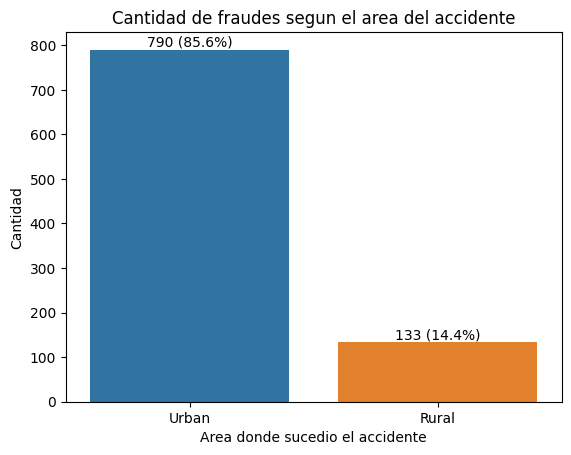

In [53]:
df_ff=df[df['fraudfound_p']==1]
count_data = df_ff['accidentarea'].value_counts()
percentage_data = df_ff['accidentarea'].value_counts(normalize=True) * 100

ax = sns.countplot(x='accidentarea', data=df_ff)

for i, v in enumerate(count_data):
    percentage = percentage_data[count_data.index[i]]
    ax.text(i, v, f"{v} ({percentage:.1f}%)", ha='center', va='bottom')
ax.set_title('Cantidad de fraudes segun el area del accidente')

ax.set_xlabel("Area donde sucedio el accidente")
ax.set_ylabel("Cantidad")

In [51]:
count_data = df.groupby(['accidentarea', 'fraudfound_p']).size().unstack().fillna(0)

table = PrettyTable()
table.field_names = ['Area del accidente', 'total de reclamaciones','Casos fraudulentos', 'Casos no fraudulentos','porcentaje reclamaciones fraudulentas']

for make, row in count_data.iterrows():
    fraudulent_count = row[1]
    non_fraudulent_count = row[0]
    tot=fraudulent_count+non_fraudulent_count
    porc_fraud=  fraudulent_count/tot
    table.add_row([make,tot, fraudulent_count, non_fraudulent_count,porc_fraud*100])

print(table)

+--------------------+------------------------+--------------------+-----------------------+---------------------------------------+
| Area del accidente | total de reclamaciones | Casos fraudulentos | Casos no fraudulentos | porcentaje reclamaciones fraudulentas |
+--------------------+------------------------+--------------------+-----------------------+---------------------------------------+
|       Rural        |          1598          |        133         |          1465         |            8.32290362953692           |
|       Urban        |         13822          |        790         |         13032         |           5.715525973086384           |
+--------------------+------------------------+--------------------+-----------------------+---------------------------------------+


** En la grafica se observa que del total de reclamaciones por siniestros, en las areas rurales el 8.5% de dichas reclamaciones resultan fraudulentas frente al 5.6% de reclamaciones fraudulentas presentadas por accidentes en areas urbanas.**

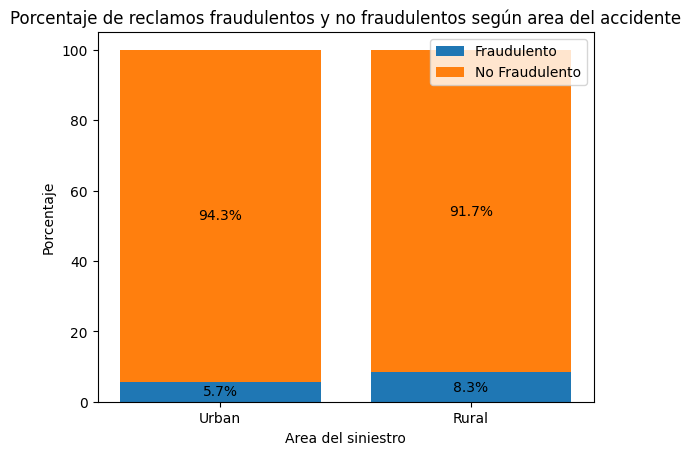

In [17]:
fraudulent_df = df[df['fraudfound_p'] == 1]
non_fraudulent_df = df[df['fraudfound_p'] == 0]

count_data_fraudulent = fraudulent_df['accidentarea'].value_counts()
count_data_non_fraudulent = non_fraudulent_df['accidentarea'].value_counts()
total_count = count_data_fraudulent + count_data_non_fraudulent
percentage_data_fraudulent = (count_data_fraudulent / total_count) * 100
percentage_data_non_fraudulent = (count_data_non_fraudulent / total_count) * 100

fig, ax = plt.subplots()
ax.bar(count_data_fraudulent.index, percentage_data_fraudulent, label='Fraudulento')
ax.bar(count_data_non_fraudulent.index, percentage_data_non_fraudulent, bottom=percentage_data_fraudulent, label='No Fraudulento')

for i, v in enumerate(percentage_data_fraudulent):
    ax.text(i, v/2, f"{v:.1f}%", ha='center', va='center')

for i, v in enumerate(percentage_data_non_fraudulent):
    ax.text(i, v/2 + percentage_data_fraudulent[i], f"{v:.1f}%", ha='center', va='center')

ax.set_title('Porcentaje de reclamos fraudulentos y no fraudulentos según area del accidente')
ax.set_xlabel("Area del siniestro")
ax.set_ylabel("Porcentaje")

ax.legend()

plt.show()


In [18]:
frauds_by_area = df.groupby('accidentarea')['fraudfound_p'].sum()

total_by_area = df['accidentarea'].value_counts()

fraud_percentage = (frauds_by_area / total_by_area) * 100

print(fraud_percentage)


accidentarea
Rural    8.322904
Urban    5.715526
dtype: float64


**Analisis de fraude de acuerdo al estado civil y genero de los reclamantes**

In [19]:
table=df.groupby(['maritalstatus', 'sex','fraudfound_p']).size().reset_index().head(50)
table= table.rename(columns={0: 'Casos','fraudfound_p':'Hubo Fraude?','sex':'Genero','maritalstatus':'estado civil'})
table

,estado civil,Genero,Hubo Fraude?,Casos
0,Divorced,Female,0,39
1,Divorced,Female,1,1
2,Divorced,Male,0,34
3,Divorced,Male,1,2
4,Married,Female,0,1261
5,Married,Female,1,64
6,Married,Male,0,8725
7,Married,Male,1,575
8,Single,Female,0,993
9,Single,Female,1,38


In [20]:

table = df.groupby(['maritalstatus', 'sex', 'fraudfound_p']).size().reset_index().rename(columns={0: 'Casos', 'fraudfound_p': 'Hubo Fraude?', 'sex': 'Genero', 'maritalstatus': 'Estado Civil'})
table['Total'] = table.groupby(['Estado Civil', 'Genero'])['Casos'].transform('sum')
table['Porcentaje de Fraude'] = (table['Casos'] / table['Total']) * 100
table = table[table['Hubo Fraude?']==1].head(50)

pretty_table = PrettyTable()
pretty_table.field_names = table.columns

for row in table.itertuples(index=False):
    pretty_table.add_row(row)

print(pretty_table)

+--------------+--------+--------------+-------+-------+----------------------+
| Estado Civil | Genero | Hubo Fraude? | Casos | Total | Porcentaje de Fraude |
+--------------+--------+--------------+-------+-------+----------------------+
|   Divorced   | Female |      1       |   1   |   40  |         2.5          |
|   Divorced   |  Male  |      1       |   2   |   36  |  5.555555555555555   |
|   Married    | Female |      1       |   64  |  1325 |  4.830188679245283   |
|   Married    |  Male  |      1       |  575  |  9300 |  6.182795698924731   |
|    Single    | Female |      1       |   38  |  1031 |  3.685741998060136   |
|    Single    |  Male  |      1       |  240  |  3653 |  6.569942513003012   |
|    Widow     | Female |      1       |   2   |   24  |  8.333333333333332   |
|    Widow     |  Male  |      1       |   1   |   11  |  9.090909090909092   |
+--------------+--------+--------------+-------+-------+----------------------+


Distribucion de las edades de las personas que hicieron reclamos  del seguro por accidentes

Text(0.5, 1.0, 'Distribución de edades de los reclamantes')

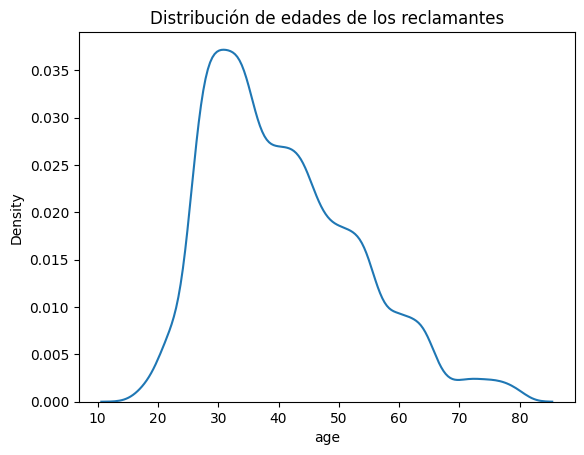

In [61]:
sns.kdeplot(data=df, x='age')
plt.title('Distribución de edades de los reclamantes')



Text(0.5, 1.0, 'Distribución de edades de los reclamantes')

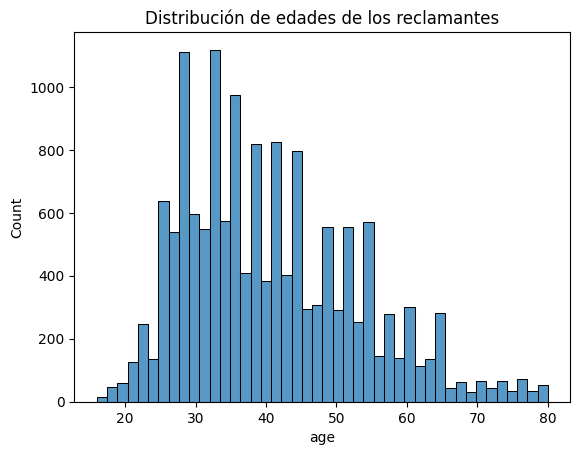

In [60]:
sns.histplot(data=df, x='age')
plt.title('Distribución de edades de los reclamantes')



**Distribucion de las edades de los reclamandes que hicieron fraude**

Text(0.5, 1.0, 'Distribución de edades de los reclamantes que hicieron fraude')

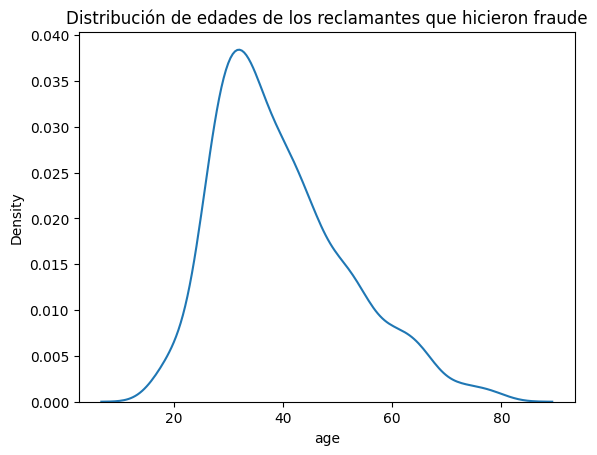

In [59]:
sns.kdeplot(data=df[df['fraudfound_p']==1], x='age')
plt.title('Distribución de edades de los reclamantes que hicieron fraude')


Text(0.5, 1.0, 'Distribución de edades de los reclamantes que hicieron fraude')

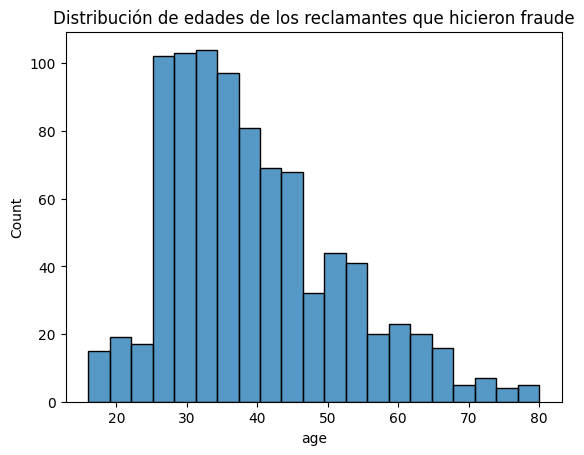

In [58]:
sns.histplot(data=df[df['fraudfound_p']==1], x='age')
plt.title('Distribución de edades de los reclamantes que hicieron fraude')


Relacion de las variables categoricas con la incidencia de reclamos fraudulentos

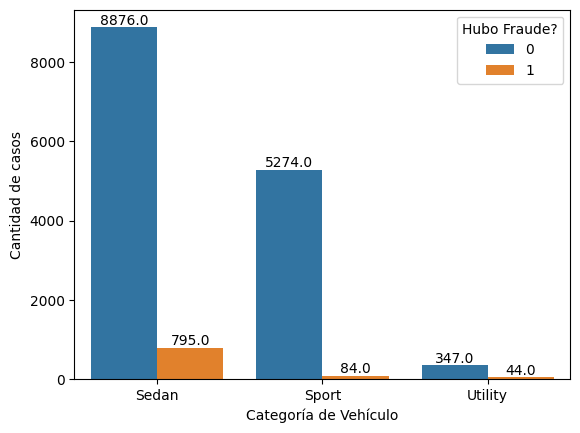

In [23]:
ax = sns.countplot(data=df, x='vehiclecategory', hue='fraudfound_p')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Categoría de Vehículo')
ax.set_ylabel('Cantidad de casos')

plt.show()


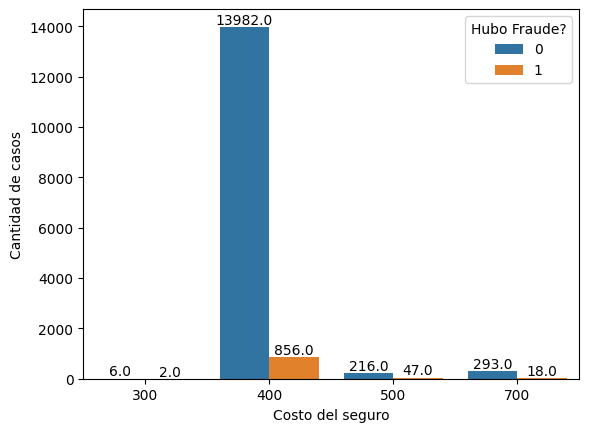

In [24]:
ax=sns.countplot(data=df, x='deductible', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Costo del seguro')
ax.set_ylabel('Cantidad de casos')

plt.show()


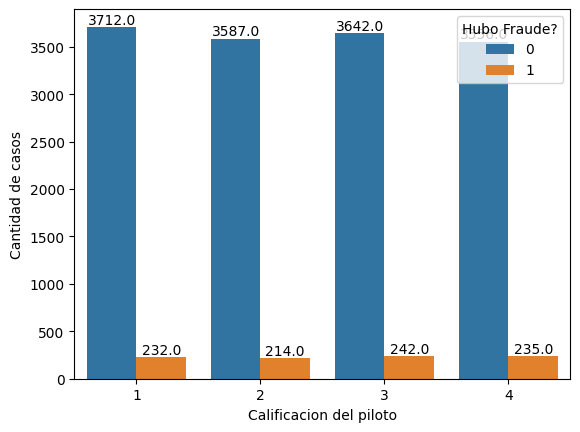

In [25]:
ax=sns.countplot(data=df, x='driverrating', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Calificacion del piloto')
ax.set_ylabel('Cantidad de casos')

plt.show()

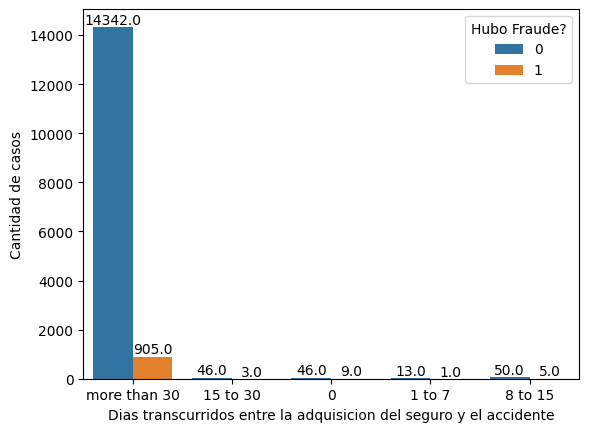

In [26]:
ax=sns.countplot(data=df, x='days_policy_accident', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Dias transcurridos entre la adquisicion del seguro y el accidente')
ax.set_ylabel('Cantidad de casos')

plt.show()

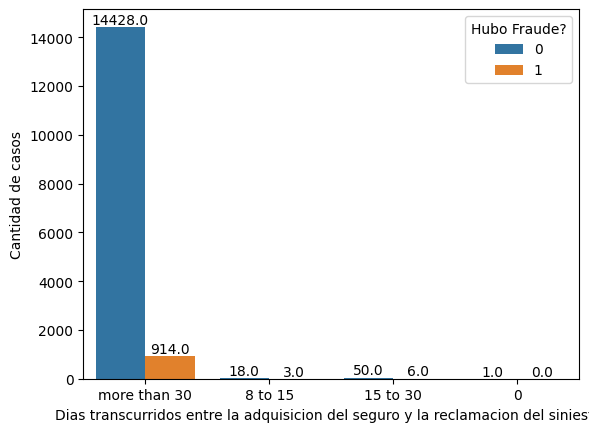

In [27]:
ax=sns.countplot(data=df, x='days_policy_claim', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Dias transcurridos entre la adquisicion del seguro y la reclamacion del siniestro')
ax.set_ylabel('Cantidad de casos')

plt.show()

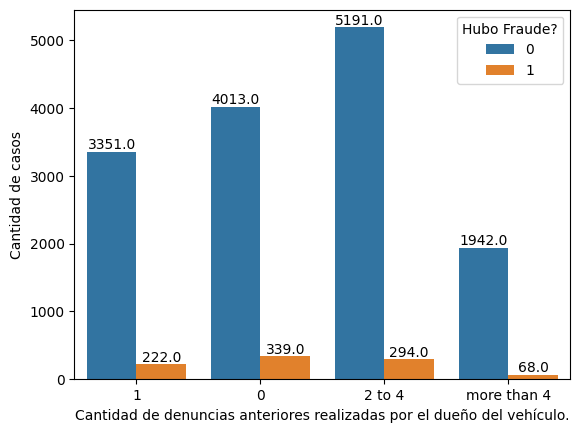

In [28]:
ax=sns.countplot(data=df, x='pastnumberofclaims', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Cantidad de denuncias anteriores realizadas por el dueño del vehículo.')
ax.set_ylabel('Cantidad de casos')

plt.show()

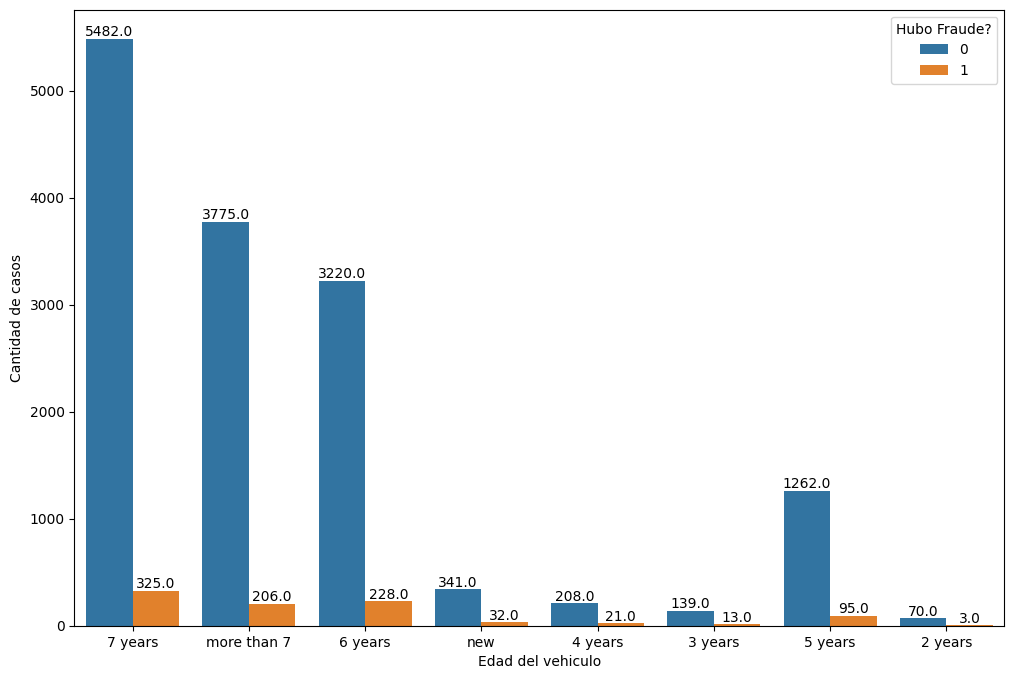

In [29]:
plt.figure(figsize=(12, 8))
ax=sns.countplot(data=df, x='ageofvehicle', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Edad del vehiculo')
ax.set_ylabel('Cantidad de casos')
plt.show()

Text(0, 0.5, 'Cantidad de casos')

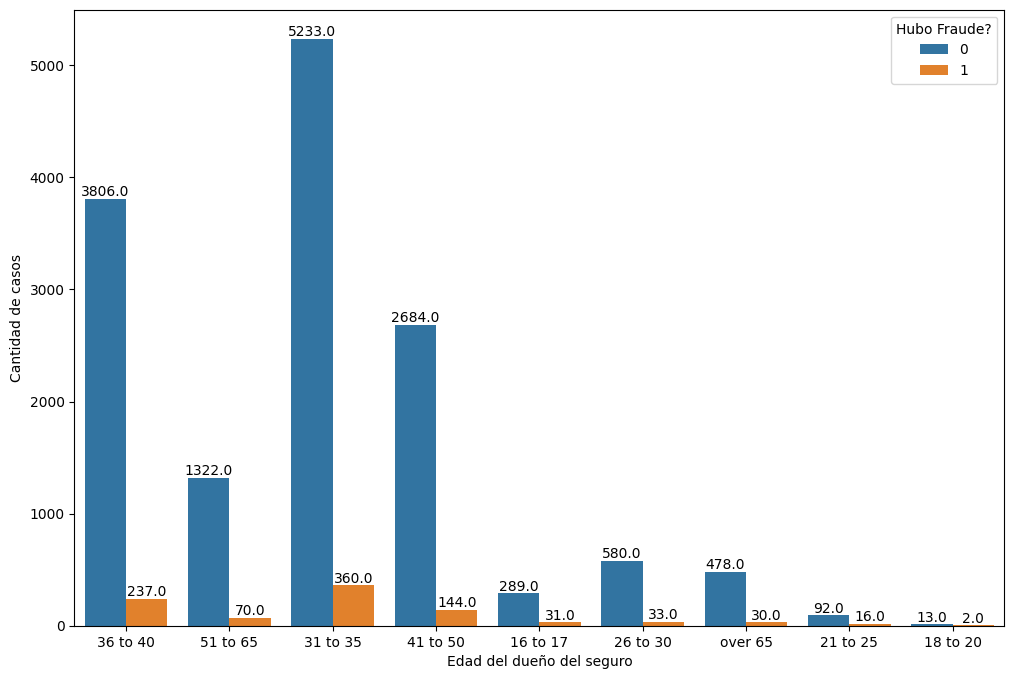

In [30]:
plt.figure(figsize=(12, 8))

ax=sns.countplot(data=df, x='ageofpolicyholder', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Edad del dueño del seguro')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

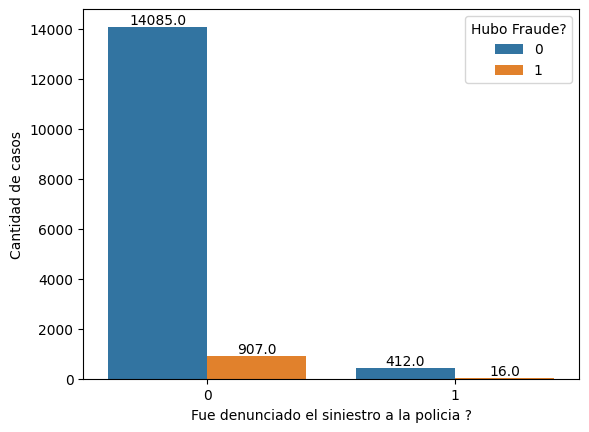

In [31]:
ax=sns.countplot(data=df, x='policereportfiled', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Fue denunciado el siniestro a la policia ?')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

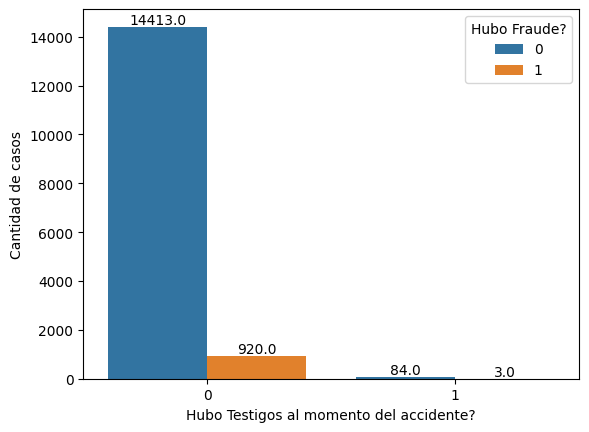

In [32]:
ax=sns.countplot(data=df, x='witnesspresent', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Hubo Testigos al momento del accidente?')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

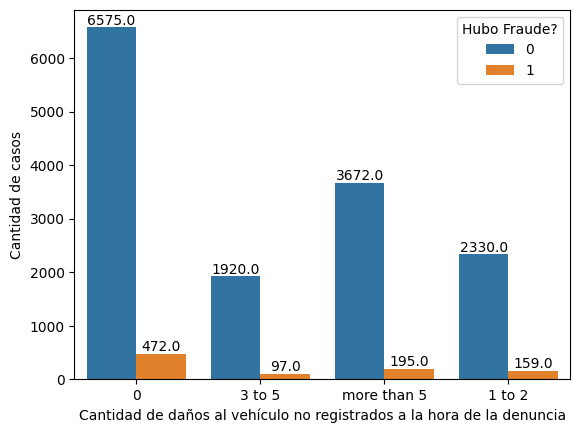

In [33]:
ax=sns.countplot(data=df, x='numberofsuppliments', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Cantidad de daños al vehículo no registrados a la hora de la denuncia')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

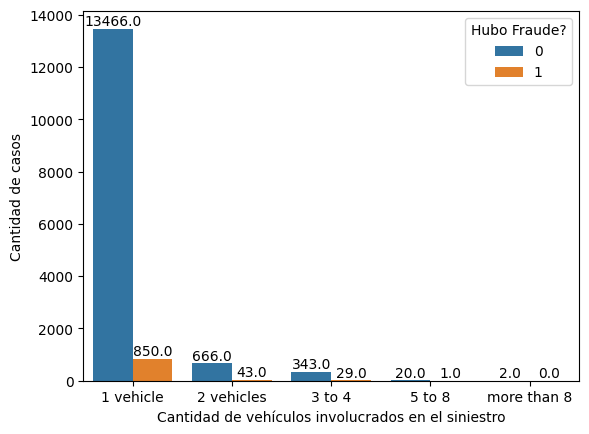

In [34]:
ax=sns.countplot(data=df, x='numberofcars', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Cantidad de vehículos involucrados en el siniestro')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

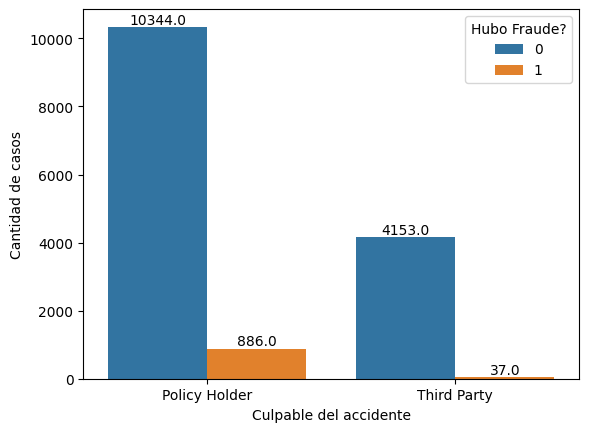

In [35]:
ax=sns.countplot(data=df, x='fault', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Culpable del accidente')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

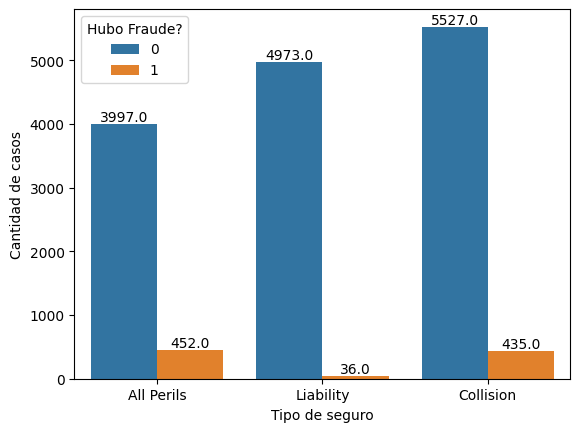

In [36]:
ax=sns.countplot(data=df, x='basepolicy', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Tipo de seguro')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

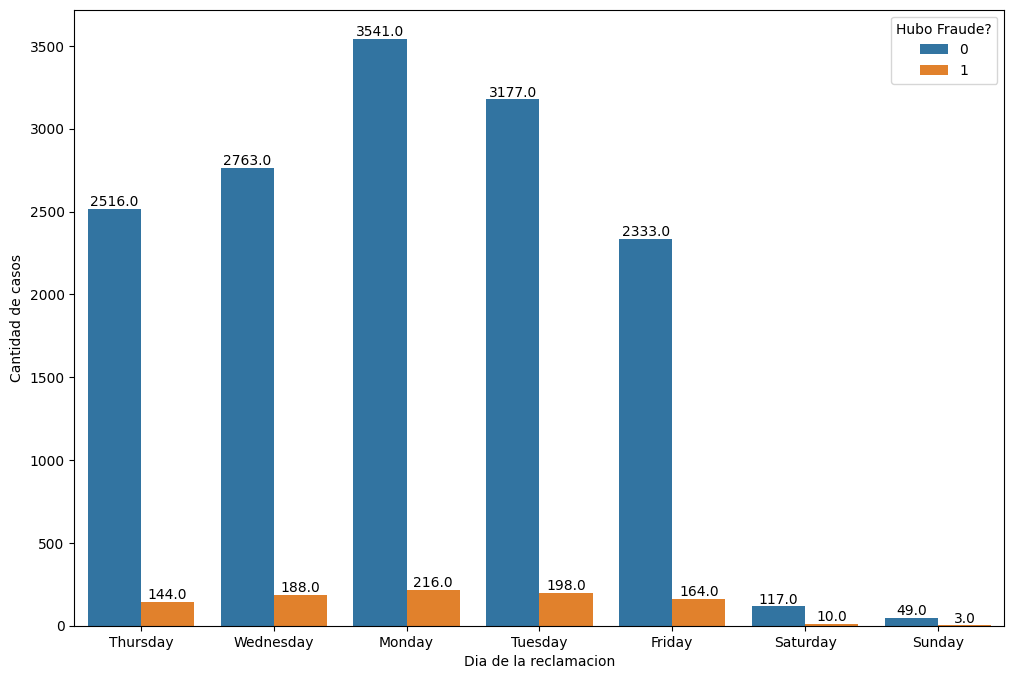

In [37]:
plt.figure(figsize=(12, 8))

ax=sns.countplot(data=df, x='dayofweekclaimed', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Dia de la reclamacion')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

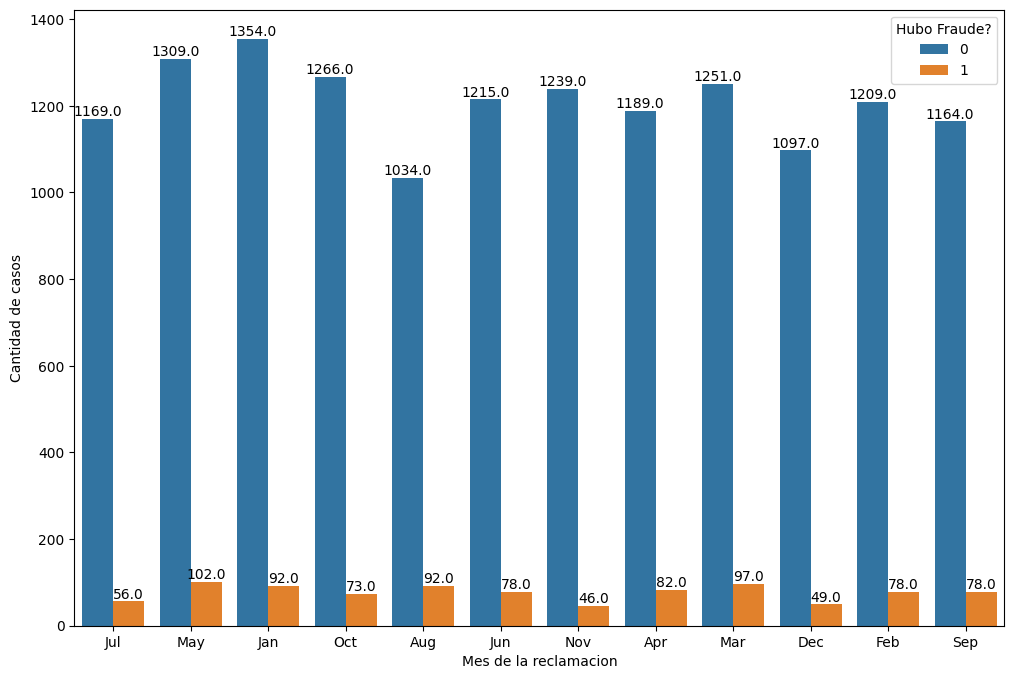

In [38]:
plt.figure(figsize=(12, 8))

ax=sns.countplot(data=df, x='monthclaimed', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Mes de la reclamacion')
ax.set_ylabel('Cantidad de casos')

Text(0, 0.5, 'Cantidad de casos')

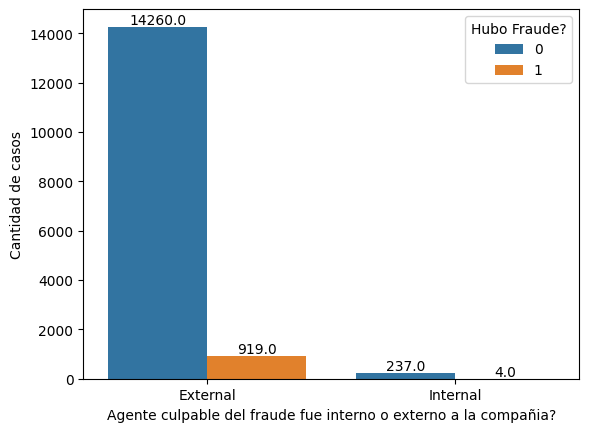

In [39]:
ax=sns.countplot(data=df, x='agenttype', hue='fraudfound_p')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom')

ax.legend(title='Hubo Fraude?')

ax.set_xlabel('Agente culpable del fraude fue interno o externo a la compañia?')
ax.set_ylabel('Cantidad de casos')

transformando las columnas que son categorias a tipo object

In [41]:
df['weekofmonth'] = df['weekofmonth'].astype(object)
df['weekofmonthclaimed'] = df['weekofmonthclaimed'].astype(object)
df['fraudfound_p'] = df['fraudfound_p'].astype(object)
df['driverrating'] = df['driverrating'].astype(object)
df['deductible'] = df['deductible'].astype(object)
df['policereportfiled'] = df['policereportfiled'].astype(object)
df['witnesspresent'] = df['witnesspresent'].astype(object)



Procedemos a calcular el coeficiente de correlacion de cramer para estudiar posibles
correlaciones entre las variable categoricas y la variable objetivo (fraudfound_p), 
con este metodo no se puede concluir claramente que existan correlaciones individuales claras entre la
variable objetivo y las variables categoricas.

In [43]:
columnas_categoricas = df.select_dtypes(include='object').columns.tolist()
print(columnas_categoricas)

['monthh', 'weekofmonth', 'dayofweek', 'make', 'accidentarea', 'dayofweekclaimed', 'monthclaimed', 'weekofmonthclaimed', 'sex', 'maritalstatus', 'fault', 'policytype', 'vehiclecategory', 'vehicleprice', 'fraudfound_p', 'deductible', 'driverrating', 'days_policy_accident', 'days_policy_claim', 'pastnumberofclaims', 'ageofvehicle', 'ageofpolicyholder', 'policereportfiled', 'witnesspresent', 'agenttype', 'numberofsuppliments', 'addresschange_claim', 'numberofcars', 'basepolicy']


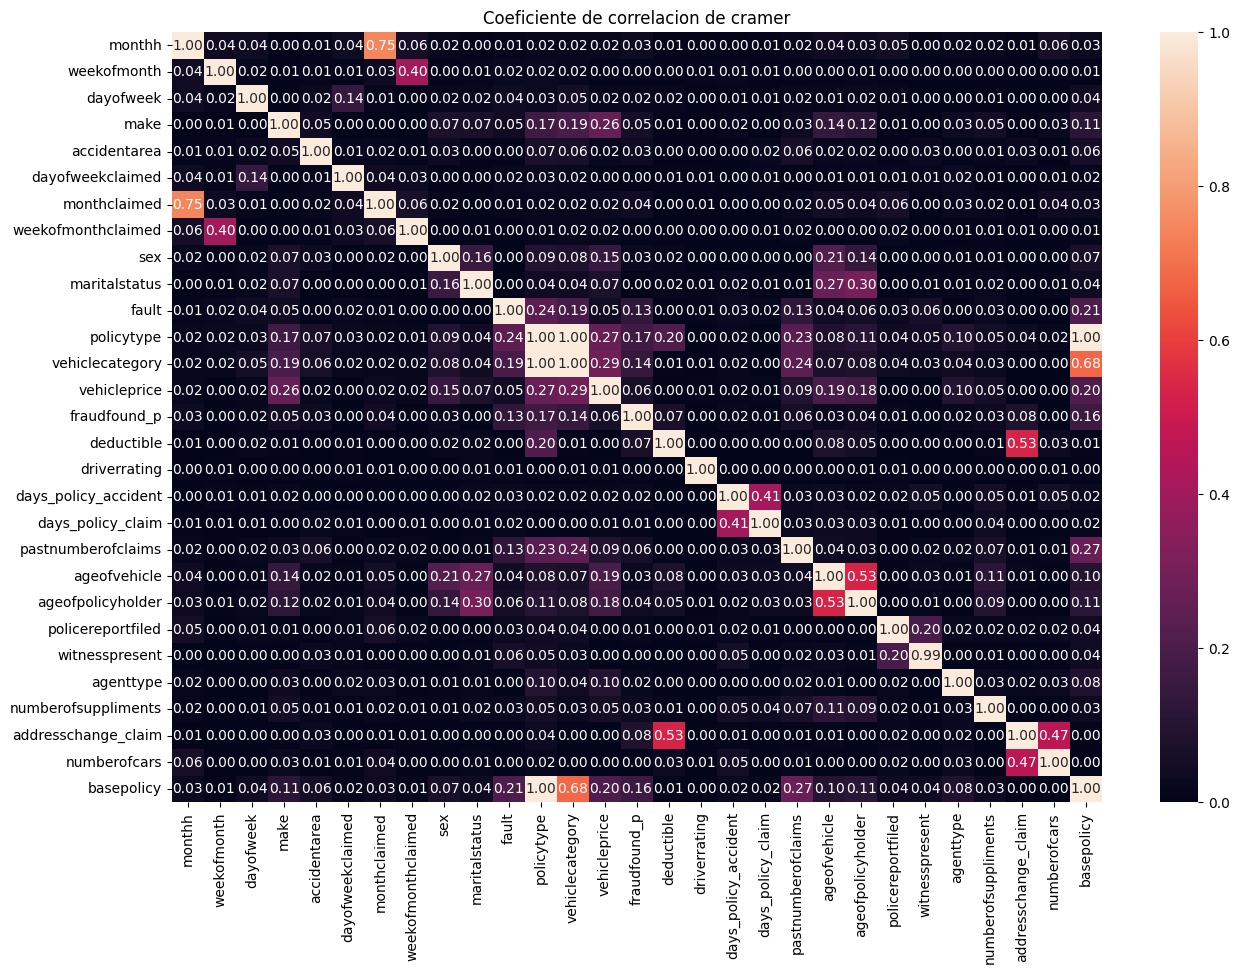

In [44]:
ob=[]
for data in df.columns:
    if data == 'fraudfound__p':
        ob.append(data)
    if df[data].dtype=='object':
        ob.append(data)
        
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

cramers_df = pd.DataFrame(index=ob)

for x in ob:
    a = []
    for y in ob:
        a.append(cramers_v(df[y], df[x]))
    cramers_df[x] = a


plt.figure(figsize=(15,10))
sns.heatmap(cramers_df, annot=True, fmt='.2f')
plt.title('Coeficiente de correlacion de cramer')
plt.show()

Almacenando el dataset  con el que se exploraron los datos

In [45]:
df.to_csv('datoseda.csv', index=False)


Recomendaciones:
Dados los insights encontrados mediante el analisis exploratorio de datos, se puede concluir que algunas de las recomendaciones para reducir las perdidas por reclamaciones fraudulentas de seguros son :

1. Manejar una discriminación en precios para automoviles de las marcas pontiac y mercedes. El motivo de la discriminación p es que se presentan un mayor numero de reclamaciones de la marca pontiac y por lo tanto puede ser conveniente elevar el precio de los seguros para este tipo de autos para contrarrestar actuarialmente las perdidas. Ademas, dada la baja cantidad de reclamaciones asociadas a carros marca mercedes y el hecho de que ya se han presentado reclamaciones fraudulentas asociadas a esta marca, tambien puede ser conveniente elevar los precios de los seguros para esta marca, estudiando primero la elasticidad de la demanda para este tipo de producto para no afectar la competitividad de la empresa en este segmento particular de ventas.


2. Exigir la denuncia del siniestro a la policia como condicion para el pago del seguro. El motivo es que al hacer la denuncia se cuenta con la investigacion policial como apoyo  para la empresa y como presion adicional en contra de aquellos que pretenden hacer fraude debido a que seria necesario pasar por un proceso investigativo mas extenso y complejo para ganar el caso de cara a las autoridades y ademas mentir en una corte o en un interrogatorio policial seria considerado un delito y seran menos personas las que esten dispuestas a correr dicho riesgo.

3. Implementar modelos de machine learning supervisado para la generación de alertas las cuales serviran para enfocar los recursos economicos y humanos dedicados a la investigacion, en aquellos casos que tienen una mayor probabilidad de ser casos de fraude, para asi no malgastar recursos investigando casos que tienen una baja probabilidad de serlo.

4. Exigir que la reclamacion del siniestro se haga en un tiempo menor a 30 dias debido a que cuando las reclamaciones se dejan pasar por mas tiempo, las probabilidades de una investigacion rigurosa y concluyente van disminuyendo y aumenta el monto total que potencialmente se puede llegar a perder por concepto de reclamos fraudulentos.
